In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import glob
import pandas as pd
from scipy import integrate
from scipy.stats import linregress
from matplotlib import cm
from matplotlib.colors import ListedColormap

In [2]:
#Constants
a=6371220 #radius of earth in m
L=2.5E6 #Latent heat in atmosphere
L_ice=3.34e5 #Latent heat of fusion
g=9.81 #Acceleration from gravity
conv_pw=1e15 #Conversion from watts to PW
cp=1007  

In [3]:
#Make some standardized coordinates

lats = np.arange(-90, 91, 1)
geometry = 2 * np.pi * np.cos(np.deg2rad(np.asarray(lats))) * a / g
levels_pa = np.array([100, 500, 1000, 2000, 3000, 5000, 7000, 10000, 15000, 20000, 25000, 30000, 40000, 50000, 60000,
             70000, 85000, 92500, 100000])
levels_hPa = levels_pa / 100

In [4]:
amip_ds = xr.open_dataset('../amip_aht.nc')
hist_ds = xr.open_dataset('../hist_aht.nc')
reanalysis_ds = xr.open_dataset('../reanalysis_aht.nc')

amip_trends = amip_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
hist_trends = hist_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)
reanalysis_trends = reanalysis_ds.groupby('time.year').mean('time').polyfit(dim = 'year', deg = 1, cov=True)

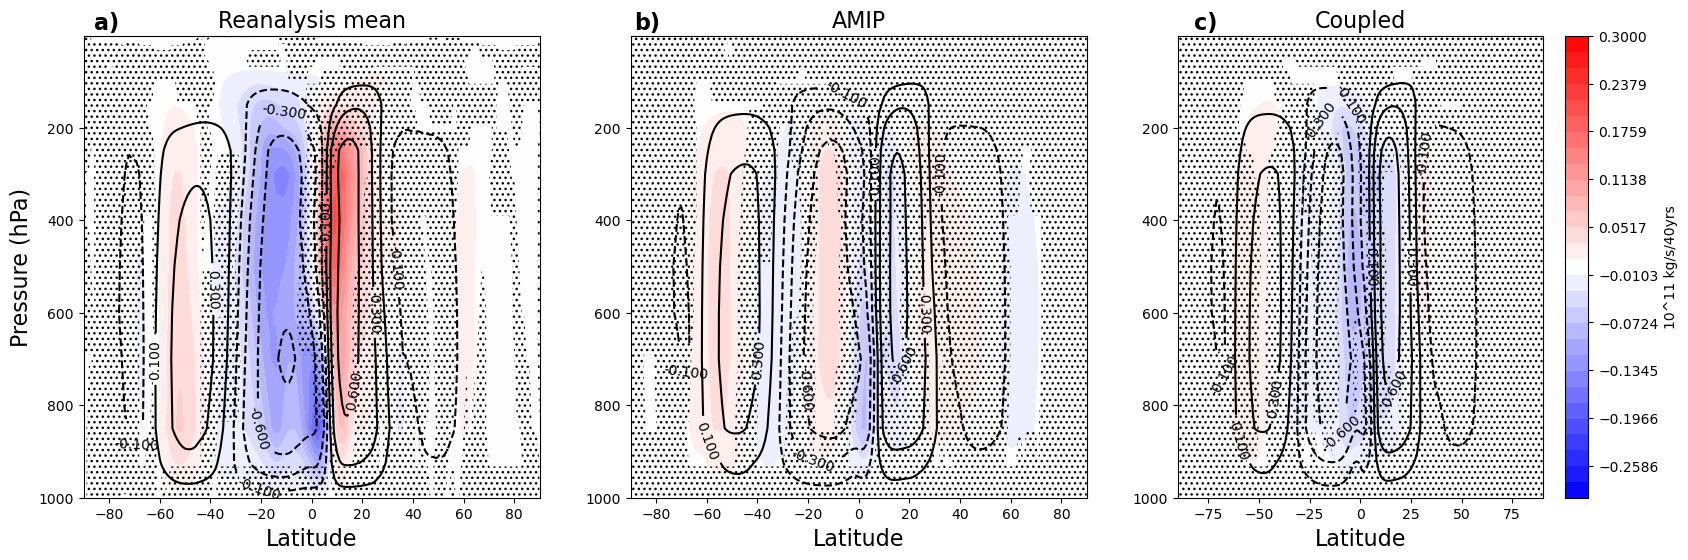

In [20]:
fig, axs = plt.subplots(1, 3, figsize=(20,6))

model_thresh = 0.9
which_levels = [-2.5, -2.0, -1.5, -1.0, -.6, -.3, -.1, .1, .3, .6, 1.0, 1.5, 2.0, 2.5]

cont=axs[0].contour(lats, levels_hPa, reanalysis_ds.strm_fnct.mean(['time', 'model'])/1e11, levels=which_levels, colors='k')

contf = axs[0].contourf(lats, levels_hPa, reanalysis_trends.strm_fnct_polyfit_coefficients.sel(degree=1).mean('model') * 40/1e11,
                     levels=np.linspace(-.3, .3, 30), cmap='bwr')

threshold = 3

counts_pos = xr.where(reanalysis_trends.strm_fnct_polyfit_coefficients.sel(degree=1) > 0, 1, 0).sum('model')
counts_neg = xr.where(reanalysis_trends.strm_fnct_polyfit_coefficients.sel(degree=1) < 0, 1, 0).sum('model')
combo = xr.where((counts_pos==threshold) | (counts_neg==threshold), 1, 0)

#To shade where they don't all agree
axs[0].contourf(lats, levels_hPa, combo, levels=[0, 0.9, 10], colors='none',
             hatches=['...', None, None], )

#To shade where they do all agree
#plt.contourf(tot_mean.latitude, tot_mean.level, combo, levels=[0, 0.9, 10], colors='none', hatches=[None, '..', None], )

#axs[0].colorbar(contf, label='10^11 kg/s/40yrs')


axs[0].invert_yaxis()

def fmt(x):
    rounded = f"{x:1f}"
    return rounded

axs[0].clabel(cont, cont.levels, inline=True,  fontsize=10)

axs[0].set_xlabel('Latitude', fontsize=16)
axs[0].set_ylabel('Pressure (hPa)', fontsize=16)
axs[0].set_title('Reanalysis mean', fontsize=16)
#plt.savefig('../figures/Nov_22/reanalysis_stream_fnct_mean_changes')
#plt.show()

cont=axs[1].contour(lats, levels_hPa, amip_ds.strm_fnct.mean(['time', 'model'])/1e11, levels=which_levels, colors='k')

contf = axs[1].contourf(lats, levels_hPa, amip_trends.strm_fnct_polyfit_coefficients.sel(degree=1).mean('model') * 40/1e11,
                     levels=np.linspace(-.3, .3, 30), cmap='bwr')


threshold = int(model_thresh * len(amip_ds.model))

counts_pos = xr.where(amip_trends.strm_fnct_polyfit_coefficients.sel(degree=1) > 0, 1, 0).sum('model')
counts_neg = xr.where(amip_trends.strm_fnct_polyfit_coefficients.sel(degree=1) < 0, 1, 0).sum('model')
combo = xr.where((counts_pos>=threshold) | (counts_neg>=threshold), 1, 0)

#To shade where they don't all agree
axs[1].contourf(lats, levels_hPa, combo, levels=[0, 0.9, 10], colors='none',
             hatches=['...', None, None])

#To shade where they do all agree
#plt.contourf(all_strm_fnct.latitude, all_strm_fnct.level/100, combo, levels=[0, 0.9, 10], colors='none',hatches=[None, '..', None], )

#plt.colorbar(contf, label='10^11 kg/s/40yrs')

axs[1].invert_yaxis()

def fmt(x):
    rounded = f"{x:1f}"
    return rounded

axs[1].clabel(cont, cont.levels, inline=True,  fontsize=10)

axs[1].set_xlabel('Latitude', fontsize=16)
#axs[1].set_ylabel('Pressure (hPa)')
axs[1].set_title('AMIP', fontsize=16)
#plt.savefig('../figures/Nov_22/amip_stream_fnct_mean_changes')
#plt.show()

cont=axs[2].contour(lats, levels_hPa, hist_ds.strm_fnct.mean(['time', 'model'])/1e11, levels=which_levels, colors='k')

contf = axs[2].contourf(lats, levels_hPa, hist_trends.strm_fnct_polyfit_coefficients.sel(degree=1).mean('model') * 40/1e11,
                     levels=np.linspace(-.3, .3, 30), cmap='bwr')


threshold = int(model_thresh * len(hist_ds.model))

counts_pos = xr.where(hist_trends.strm_fnct_polyfit_coefficients.sel(degree=1) > 0, 1, 0).sum('model')
counts_neg = xr.where(hist_trends.strm_fnct_polyfit_coefficients.sel(degree=1) < 0, 1, 0).sum('model')
combo = xr.where((counts_pos>=threshold) | (counts_neg>=threshold), 1, 0)

#To shade where they don't all agree
axs[2].contourf(lats, levels_hPa, combo, levels=[0, 0.9, 10], colors='none',
             hatches=['...', None, None])

#To shade where they do all agree
#plt.contourf(all_strm_fnct.latitude, all_strm_fnct.level/100, combo, levels=[0, 0.9, 10], colors='none',hatches=[None, '..', None], )

fig.colorbar(contf, ax=axs[2], label='10^11 kg/s/40yrs')

axs[2].invert_yaxis()

def fmt(x):
    rounded = f"{x:1f}"
    return rounded

plt.clabel(cont, cont.levels, inline=True,  fontsize=10)

axs[2].set_xlabel('Latitude', fontsize=16)
#axs[2].set_ylabel('Pressure (hPa)')
axs[2].set_title('Coupled', fontsize=16)

fig.text(0.13, 0.89, 'a)', fontsize=16, fontweight='semibold')
fig.text(0.4, 0.89, 'b)', fontsize=16, fontweight='semibold')
fig.text(0.68, 0.89, 'c)', fontsize=16, fontweight='semibold')

#plt.savefig('../figures/streamfunction_changes')


plt.show()